In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Extract
raw = sns.load_dataset("penguins")
raw.head()



,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [8]:
# Transform
# Standardise column names
# Drop missing rows for key variables
# Create a simple feature: Mass per flipper
# Add an outlier flag using IQR rule
df = raw.copy()
df = df.rename(columns={c: c.replace("_", " ").title() for c in df.columns})
df["Mass/Flipper"] = df["Body Mass G"] / df["Flipper Length Mm"]

def iqr_flags(s):
    """ Calculating inter quartile range and returning True or False"""
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return (s < low) | (s > high)

for col in [
    "Bill Length Mm",
    "Bill Depth Mm",
    "Flipper Length Mm",
    "Body Mass G",
    "Mass/Flipper"
]:
    df[f"{col} Outlier"] = iqr_flags(df[col])

df.to_csv("penguins_cleaned.csv", index=False)

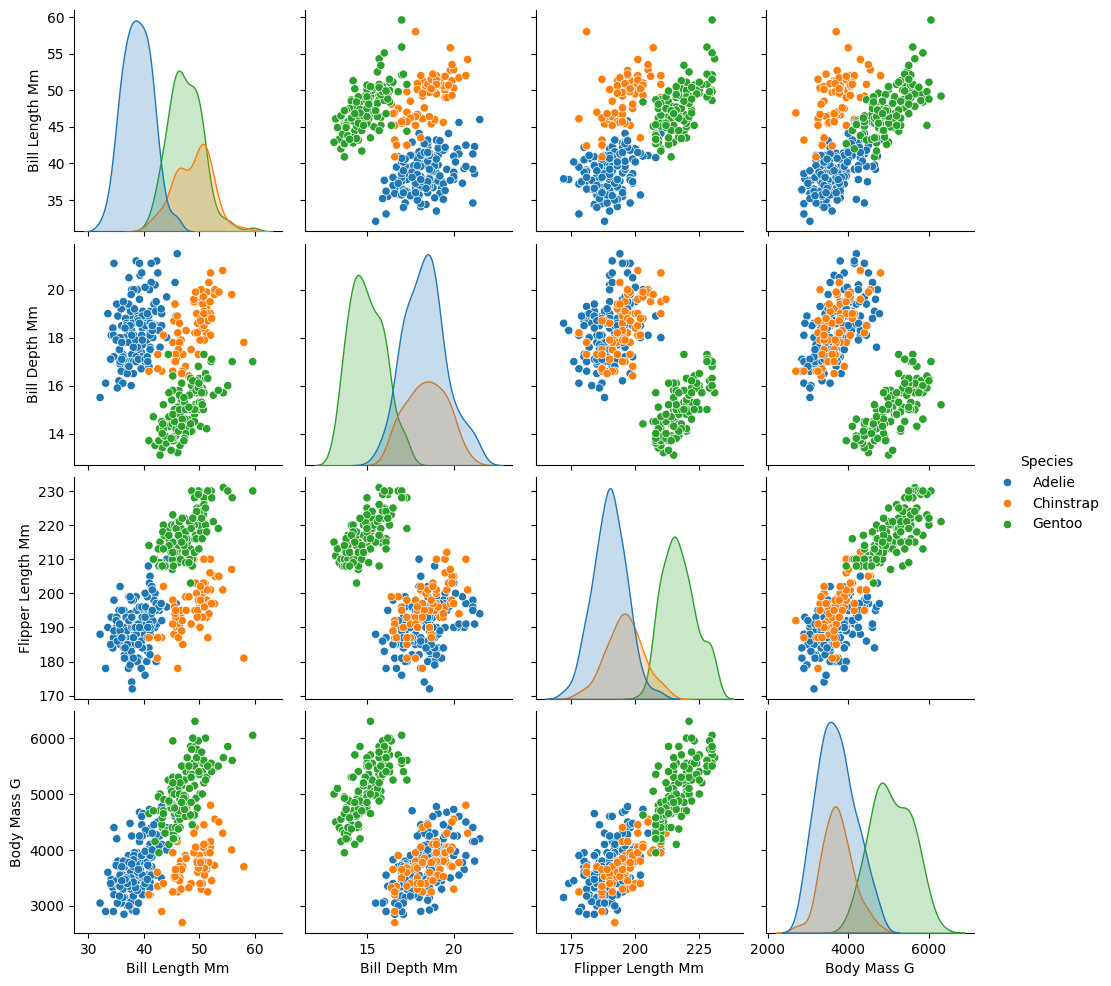

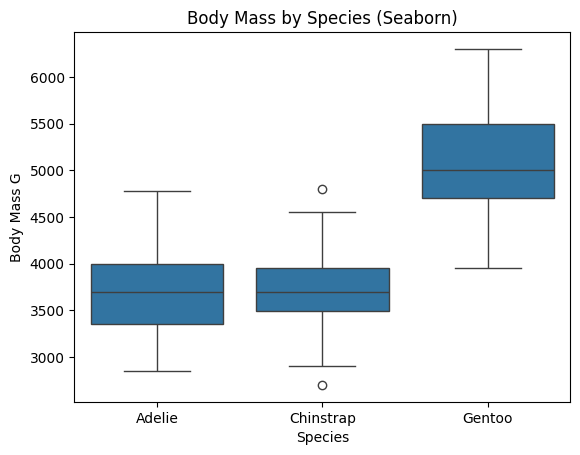

In [10]:
sns.pairplot(df, vars=["Bill Length Mm","Bill Depth Mm","Flipper Length Mm","Body Mass G"], hue="Species")
plt.show()

sns.boxplot(data=df, x="Species", y="Body Mass G")
plt.title("Body Mass by Species (Seaborn)")
plt.show()



In [11]:
fig = px.scatter(
    df, x="Bill Length Mm", y="Bill Depth Mm", color="Species",
    hover_data=["Island","Sex","Flipper Length Mm","Body Mass G","Mass/Flipper"],
    marginal_x="histogram", marginal_y="violin", opacity=0.85,
    title="Bill: Length vs Depth — with marginals"
)
fig.show()

In [12]:
fig = px.histogram(
    df, x="Body Mass G", color="Species",
    nbins=30, barmode="overlay", opacity=0.60,
    facet_row="Sex"
)
fig.show()

In [16]:
px.box(df, x="Species", y="Body Mass G", points="all").show()

In [17]:
px.violin(df, x="Species", y="Body Mass G", box=True, points="all").show()

In [18]:
fig = px.scatter(
    df, x="Flipper Length Mm", y="Body Mass G", 
    color="Species", facet_col="Sex", facet_row="Island",
    height=700, opacity=0.85
)
fig.show()

In [19]:
fig = px.scatter_3d(
    df, x="Bill Length Mm", y="Bill Depth Mm", z="Flipper Length Mm",
    color="Species", symbol="Sex", opacity=0.8
)
fig.show()

In [20]:
# Parallel Categories
df["Mass Bucket"] = pd.cut(
    df["Body Mass G"],
    bins=[0, 3800, 4400, 9999],
    labels=["Light", "Medium", "Heavy"])
px.parallel_categories(
    df, dimensions=["Species", "Island", "Sex", "Mass Bucket"],
    color="Body Mass G", color_continuous_scale=px.colors.sequential.Viridis
).show()

In [25]:
species_list = sorted(df["Species"].unique())
traces = []
for sp in species_list:
    sub = df[df["Species"] == sp]
    traces.append(go.Scatter(
        x=sub["Flipper Length Mm"], y=sub["Body Mass G"],
        mode="markers", name=sp,
        hovertemplate="<b>%{text}</b><br>Flipper: %{x} mm<br>Mass: %{y} g<extra></extra>",
        text=sub["Island"] + " | " + sub["Sex"].astype(str)        
    ))

fig = go.Figure(data=traces)
buttons = [dict(
    label="All",
    method="update",
    args=[{"visible": [True]*len(species_list)}]
)]
for i, sp in enumerate(species_list):
    vis = [False]*len(species_list)
    vis[i] = True
    buttons.append(dict(label=sp, method="update", args=[{"visible": vis}]))

fig.update_layout(
    title="Mass vs Flipper Length — Dropdown by Species",
    updatemenus=[dict(type="dropdown", x=1.0, xanchor="right", y=1.15, buttons=buttons)]
)
fig.show()

In [26]:
px.scatter(
    df, x="Bill Length Mm", y="Bill Depth Mm", color="Species",
    hover_data={
        "Island": True,
        "Sex": True,
        "Flipper Length Mm":":.0f",
        "Body Mass G":":.0f",
        "Mass/Flipper":":.2f",
        "Bill Length Mm":False,
        "Bill Depth Mm":False
    },
    title="Custom Hover: formatted and simplified"
).show()


In [27]:
fig.write_html("penguins_plotly_showcase.html", include_plotlyjs="cdn")